Last month, I came across [this article](http://crime.static-eric.com/) which talked about the link between weather and crime: apparently, higher temperatures are correlated with higher crime rates. This is one of those things that you know could be true and yet don't *sound* true- like the fact that Donald Trump's campaign manager was indicted for certain crimes, and this is true, because he made changes to a document in MS Word from his own username, and the prosecutors - experienced, intelligent criminal lawyers - used 'Track Changes'.

On digging a little more, I found a large body of findings and possible explanations for why this might be the case - [this study](https://www.nytimes.com/2013/09/01/opinion/sunday/weather-and-violence.html) reported in the New York Times talked about how extreme weather events always lead to an increase in violence. [This article](http://www.chicagotribune.com/news/data/ct-crime-heat-analysis-htmlstory.html) in the Chicago Tribune also talks about an increase in violent crimes. [This article](https://www.sciencedaily.com/releases/2017/09/170925132948.htm) links violence to all increases in temperature - even warmer winter days. There is a large variety of explanations - from [sociological](https://pdfs.semanticscholar.org/4760/63974fc8703e2e4157153e77898bc89d92b5.pdf) to [neuroscientific](https://grist.org/climate-energy/hunting-for-the-neuroscience-of-heat-and-violence/) to simple (higher temperature => more people outside => more opportunities for crime => more crime).


Whatever be the explanation, the link itself is surprising (and intriguing). To explore it further, someone would have to sit down and get crime data for cities wherever publicly available, get the weather data for that time period and then manipulate that to find a correlation and whether or not the effect is statistically significant.

But who would do that?

The answer, dear reader, is me. I would do that. For ten different cities in North America. Over a six-year time period, wherever full data was available.

For the record, before I start, I know this correlation doesn't imply causation. I'm not trying to prove higher temperature causes higher crime. I have neither the intention nor the 30-year experience in sociology to do that. I'm just marveling at how damn cool it is that the correlation exists in the first place.

Now, let's get into it.

The Baltimore police department hosts datasets of all crimes reported, by year, [here](https://data.baltimorecity.gov/Public-Safety/BPD-Part-1-Victim-Based-Crime-Data/wsfq-mvij). (I'm choosing Baltimore here because it's supposed to have a high crime rate, because it strongly indicates this phenomenon, and because I watched, like, two whole episodes of *The Wire*).  

The data includes 15 different types of crime, including Auto Theft, Larceny, Arson, Robbery, Common Assault, Burglary, etc. I did not see any reason to filter out any of them.

I'm only interested in the sum total of all crimes, so here's a look at the trend in the total daily crime over the years:

\[Note: To make this notebook easier to read, I've collapsed all the code by default. If you want to toggle
displaying the code, click the nice button below.\]

In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="This is the only button, dumbass.">
 </form>'
)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



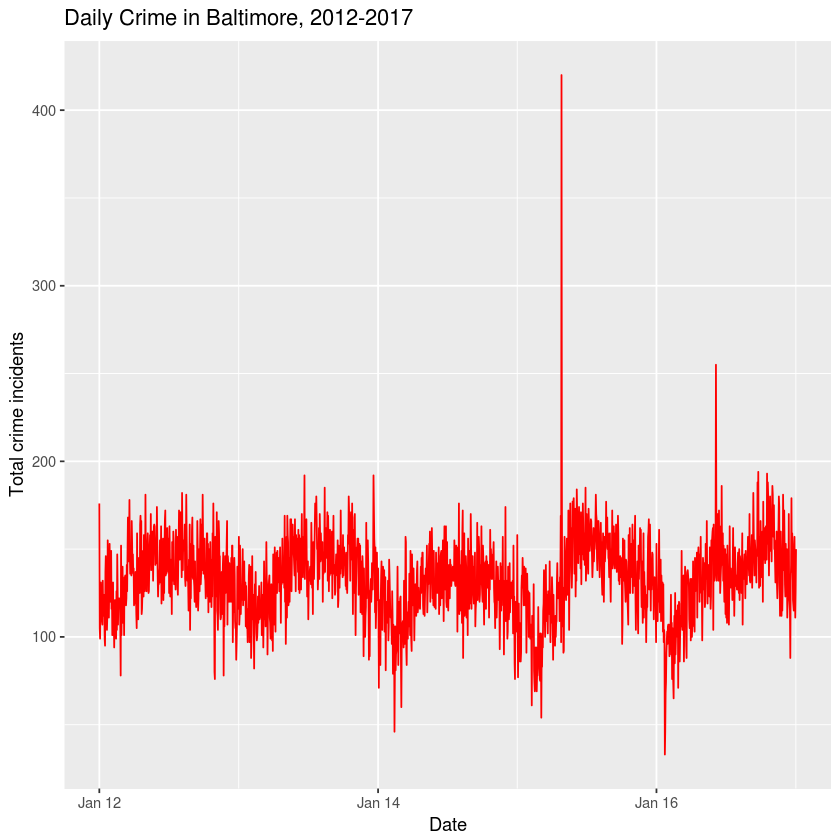

In [2]:
baltimore_daily_crime <- read.csv('/home/ab/Downloads/Datasets for analysis/Crime Data/baltimore_crime_by_date.csv', header = TRUE, stringsAsFactors = FALSE)
#plot(ts(atlanta_daily_crime$observations, frequency = 365.25, start = c(2013)),
#    main = 'Daily Crime in Atlanta, 2013-2017', xlab = 'Date',ylab = 'Total crime incidents', col = 'red')
library(ggplot2)
library(lubridate)
library(scales)
baltimore_daily_crime$CrimeDate <- as.Date(baltimore_daily_crime$CrimeDate)
b_crime <- ggplot(baltimore_daily_crime, aes(CrimeDate, Total.Incidents, group = 1)) +
           geom_line(na.rm=TRUE, color="red") +  
           ggtitle("Daily Crime in Baltimore, 2012-2017") +
           xlab("Date") + ylab("Total crime incidents") +
           scale_x_date(labels=date_format("%b %y"))
b_crime

The huge spike that you see around mid-2015 is from the [wave of protests](https://en.wikipedia.org/wiki/2015_Baltimore_protests) which took in Baltimore on 27th April 2015 after the death of Freddie Gray, an African American resident, in police custody.

In our data, in the given context, that is an outlier. Using the handy 'outliers' package, and allowing large variance in crime (only flagging the days beyond the 99.9th percentile of t-score as outliers), 8 days in total are flagged as outliers. I'll replace them with the median for now. Here's a look at the crimes committed per day after removing these:



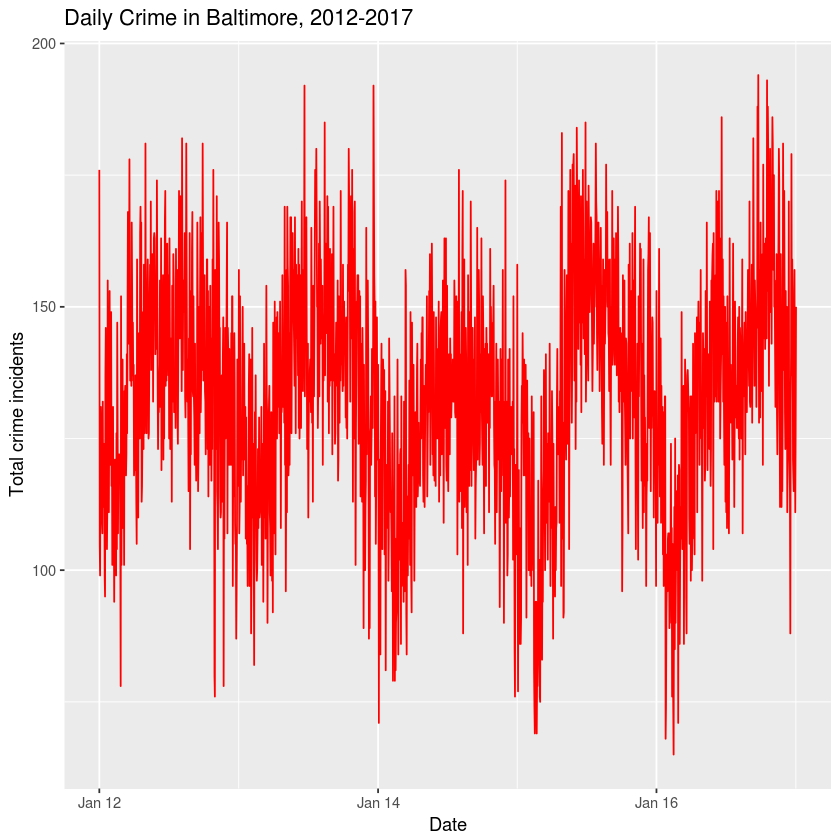

In [3]:
library(outliers)
#scores(baltimore_daily_crime$Total.Incidents, type = "t", prob = 0.995)
baltimore_daily_crime$Total.Incidents[which(scores(baltimore_daily_crime$Total.Incidents, type = "t", prob = 0.999) == 1)] <- median(baltimore_daily_crime$Total.Incidents)
b_crime <- ggplot(baltimore_daily_crime, aes(CrimeDate, Total.Incidents, group = 1)) +
           geom_line(na.rm=TRUE, color="red") +  
           ggtitle("Daily Crime in Baltimore, 2012-2017") +
           xlab("Date") + ylab("Total crime incidents") +
           scale_x_date(labels=date_format("%b %y"))
b_crime

The NOAA (National Oceanic and Atmospheric Administration) website is very helpful. If you go there and fill out a request for weather data for Baltimore, for example, for 2012-2017, from the Martin Field Airport (the closest weather observatory to the city), they will email the csv for free to you in about five minutes. Since I'm only interested in the maximum temperature (in Fahrenheit) on any given day, here's a look at the daily maximum temperatures in Baltimore for that period:


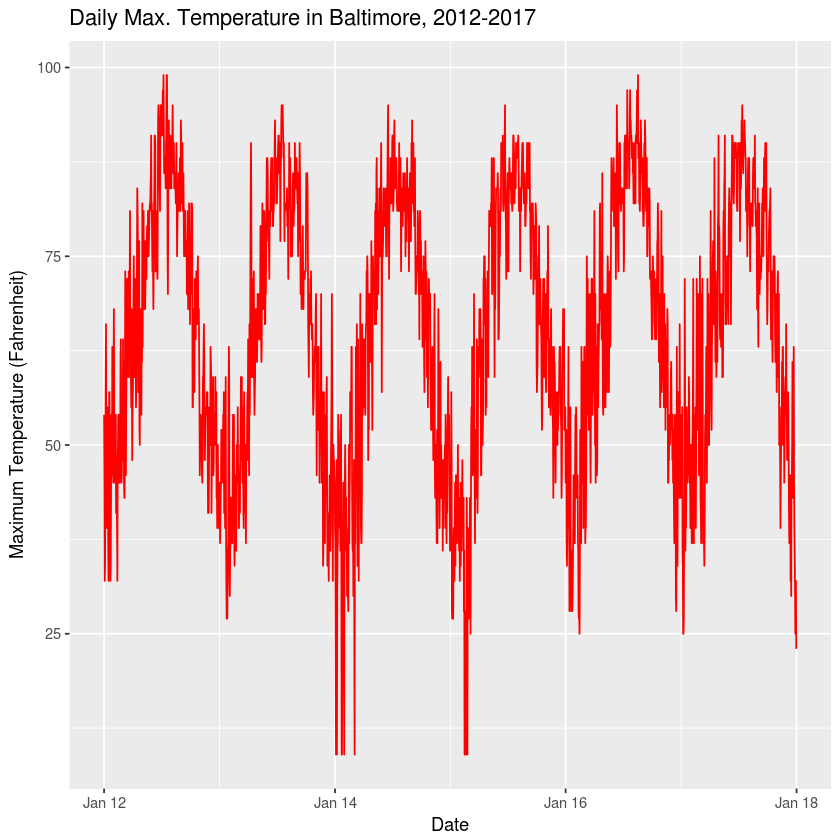

In [4]:
baltimore_daily_weather <- read.csv('/home/ab/Downloads/Datasets for analysis/Crime Data/baltimore_daily_weather.csv', stringsAsFactors = FALSE)
#plot(ts(atlanta_daily_weather$DAILYMaximumDryBulbTemp))
library(ggplot2)
library(lubridate)
library(scales)
baltimore_daily_weather$DATE <- as.Date(baltimore_daily_weather$DATE)
b_weather <- ggplot(baltimore_daily_weather, aes(DATE, HOURLYDRYBULBTEMPF, group = 1)) +
           geom_line(na.rm=TRUE, color="red") +  
           ggtitle("Daily Max. Temperature in Baltimore, 2012-2017") +
           xlab("Date") + ylab("Maximum Temperature (Fahrenheit)") +
           scale_x_date(labels=date_format("%b %y"))
b_weather

You might already be able to see the similarity in the seasonality exhibited by both of those time series. Just to formalise, I'll coerce both into a dataframe so that you get a day's maximum temperature and the total crimes committed on that day together neatly.

So, here's a look at how the crime actually varies by temperature in Baltimore:


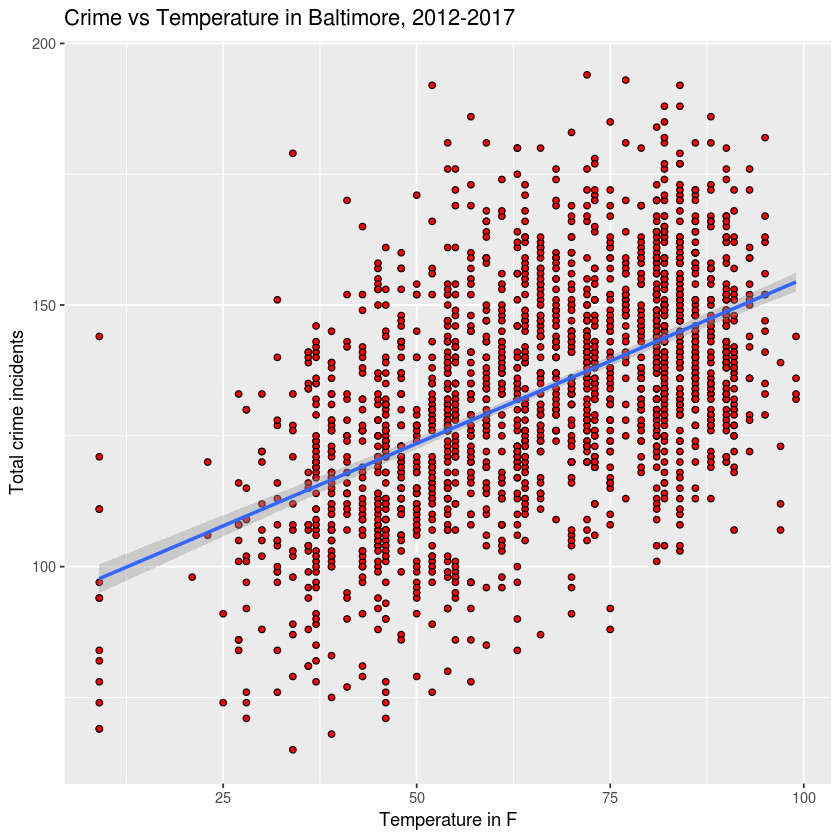

In [5]:
baltimore_crime_weather <- read.csv('/home/ab/Downloads/Datasets for analysis/Crime Data/baltimore_crime_vs_weather.csv', stringsAsFactors = FALSE)
library(ggplot2)
library(scales)
b_crime_weather <- ggplot(baltimore_crime_weather, aes(x = HOURLYDRYBULBTEMPF, y = Total.Incidents)) +
        geom_point(shape = 21, fill = "red") +
        ggtitle("Crime vs Temperature in Baltimore, 2012-2017") +
        labs(x = "Temperature in F", y = "Total crime incidents") +
        geom_smooth(method='lm')
b_crime_weather

I think the correlation is pretty clear from the scatter plot. I still need to formally verify that the effect of crime on weather would be statistically significant, though. Good old lm(), with crime as the dependent variable and only the maximum temperature as the predictor, will do that for me. I'll also find the actual correlation between the two variables, while I'm at it.

In [6]:
lm_baltimore <- lm(Total.Incidents ~ HOURLYDRYBULBTEMPF, baltimore_crime_weather)
summary(lm_baltimore)
print('The correlation between incidents of crime and temperature in Baltimore is:')
cor(baltimore_crime_weather$Total.Incidents, baltimore_crime_weather$HOURLYDRYBULBTEMPF)


Call:
lm(formula = Total.Incidents ~ HOURLYDRYBULBTEMPF, data = baltimore_crime_weather)

Residuals:
    Min      1Q  Median      3Q     Max 
-51.288 -12.248  -0.609  12.157  67.201 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        92.04014    1.59548   57.69   <2e-16 ***
HOURLYDRYBULBTEMPF  0.62997    0.02365   26.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.27 on 1825 degrees of freedom
Multiple R-squared:   0.28,	Adjusted R-squared:  0.2796 
F-statistic: 709.6 on 1 and 1825 DF,  p-value: < 2.2e-16


[1] "The correlation between incidents of crime and temperature in Baltimore is:"


[1] 0.5291145

The p-value for the Temperature variable is < 2.2e-16, or *pretty damn significant*. And the actual correlation between the two variables is 0.529, which is also very strong if you ask me.

This general procedure remains the same for the other cities:

1. Get the data/scrape it from the Police Deparment website (or from wherever a kind soul cleaned and uploaded it on Kaggle),
2. Fill out a request on the NOAA website for the required period, or scrape the weather data using R packages (looking at you, Weather Canada), and
3. Look'em against each other, check if the effect is statistically significant with lm(), and get the correlation.

Then you spend about three weekends doing that for ten different police departments and banging your laptop on the floor because most Canadian stations just won't give you the data for Vancouver, and your laptop dies on you because you tried to ingest six million crime records from New York City, and  and then **bam!** you have a result!

### The effects of increase in Temperature on crime are statistically significant.

In all ten cities across North America: Atlanta, Baltimore, New York, Philadelphia, Chicago, Los Angeles, Baton Rouge, Portland, Minneapolis and Vancouver, higher temperatures *are* associated with more crime.

To illustrate, I'll plot the Crime vs Temperature scatter plot for a couple more cities.

In Atlanta:

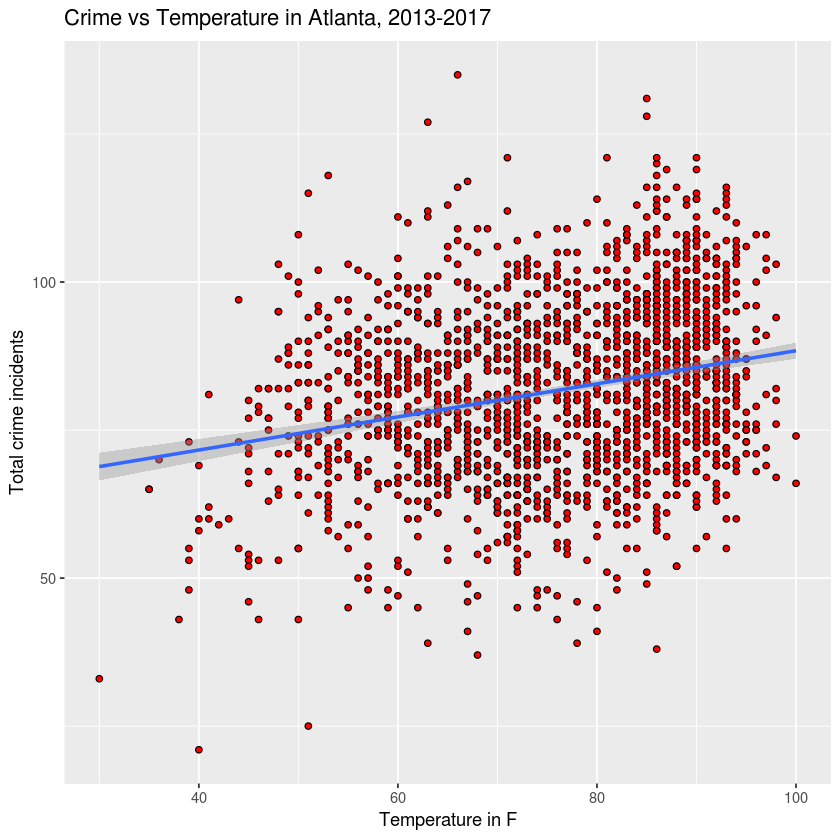

In [10]:
atlanta_crime_weather <- read.csv('/home/ab/Downloads/Datasets for analysis/Crime Data/atlanta_crime_vs_weather.csv', stringsAsFactors = FALSE)
library(ggplot2)
library(scales)
at_crime_weather <- ggplot(atlanta_crime_weather, aes(x = DAILYMaximumDryBulbTemp, y = observations)) +
        geom_point(shape = 21, fill = "red") +
        ggtitle("Crime vs Temperature in Atlanta, 2013-2017") +
        labs(x = "Temperature in F", y = "Total crime incidents") +
        geom_smooth(method='lm')
at_crime_weather